We use data augmentation techniques and transforms to work on our CIFAR10 dataset.

Random Crop This technique creates a random subset of an original image.

Random Horizontal Flip This technique flips an image horizontally with a probability p.

To Tensor: It converts PyTorch tensor and scales the image by 255.

Normalize: It transforms the images such that the values, mean and standard deviation of the image become 0.0 and 1.0 respectively

We download our CIFAR10 dataset in root directory ./data

To ensure we get the same validation set each time, we set PyTorch’s random number generator to a seed value of 17. Also we imported the datasets and converted the images into PyTorch tensors.

In [ ]:
import multiprocessing
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(17)

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

class FetchDataset:

    def __init__(self, dataset="CIFAR10", batch_size=64):
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.transformers_training = []
        self.transformers_testing = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)
      
    def dataAugmentation(self, size=32, padding=3):
        self.transformers_training.append(transforms.RandomHorizontalFlip())
        self.transformers_training.append(transforms.RandomCrop(size=size, padding=padding))
        self.transformers_training.append(transforms.functional.equalize)
        self.transformers_testing.append(transforms.functional.equalize)

    def __addToTensor(self):
        self.transformers_training.append(transforms.ToTensor())
        self.transformers_testing.append(transforms.ToTensor())

    def addNormalizer(self):
        self.__addToTensor()
        dataset_training = self.datasetObject(root="./data", train=True, download=True)
        data_train = dataset_training.data/255.0
        mean = data_train.mean(axis=(0, 1, 2))
        std = data_train.std(axis=(0, 1, 2))
        self.transformers_training.append(transforms.Normalize(mean=mean, std=std))
        self.transformers_testing.append(transforms.Normalize(mean=mean, std=std))
        

    def getLoaders(self):
        if len(self.transformers_training) == 0:
            self.__addToTensor()
        dataset_training = self.datasetObject(root="./data", train=True, download=True, transform=transforms.Compose(self.transformers_training))
        dataset_testing = self.datasetObject(root="./data", train=False, download=True, transform=transforms.Compose(self.transformers_testing))
        load_train = DataLoader(dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=self.workersAvailable)
        load_test = DataLoader(dataset_testing, batch_size=self.batch_size, shuffle=False, num_workers=self.workersAvailable)
        return load_train, load_test
    

df = FetchDataset(dataset="CIFAR10", batch_size=128)
df.dataAugmentation(size=32, padding=4)
df.addNormalizer()
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Modified the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py 

• Ci, the number of channels in the ith layer.
• Fi, the filter size in the ith layer
• Ki, the kernel size in the ith skip connection
• P, the pool size in the average pool laye

Using the following values for the Hyperparameters (design variables) in our architectures : 

    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]  
    P=4



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        for layer in self.layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.P)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():

    B=[3,3,2,3]
    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = project1_model()
model = model.to(device)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


We run our model for 300 epochs, to find out the best possible accuracy. The accuracy becomes near about constant after it. We define our:

learning rate, weightDecay, type of optimizer to be used (we tried with Adam, Adagrad, AdaDelta), with Adadelta giving out the best accuracy.

The scheduler set the learning rate of each parameter group using a cosine annealing schedule


In [ ]:
EPOCHS=300
globalBestAccuracy = 0.0
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

loss_function = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.01
weightDecay = 0.0001
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Exceeds the total number of parameters required!")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Model Training and Testing.
Here we are training our model over 300 epochs and trying to find out the best accuracy our model provides for the CIFAR dataset.

In [ ]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

def test(model,loader):
    return model.eval() 

def getLoss(loader,model,optimizer):
    running_loss = 0.0
    running_correct = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = loss_function(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(predicted_labels == labels).float().item()
        if phase == "train":
            loss.backward()
            optimizer.step()
    return running_loss,running_correct

for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model,optimzier= train(model,loader,optimizer)
        else:
            loader = testLoader
            model=test(model,loader)
        running_loss,running_correct = getLoss(loader,model,optimizer)
        epoch_loss = running_loss/len(loader.dataset)
        epoch_acc = running_correct/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        else:
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            globalBestAccuracy = max(globalBestAccuracy, epoch_acc) 
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1]))

  0%|          | 1/300 [00:52<4:20:33, 52.29s/it]

Training Loss : 1.6979391136169433, Testing Loss : 1.5493085527420043, Training Accuracy : 0.3618, Testing Accuracy : 0.4402


  1%|          | 2/300 [01:37<3:58:54, 48.10s/it]

Training Loss : 1.4453149530029297, Testing Loss : 1.3776496660232544, Training Accuracy : 0.46612, Testing Accuracy : 0.5068


  1%|          | 3/300 [02:22<3:50:54, 46.65s/it]

Training Loss : 1.2446753140258788, Testing Loss : 1.1952937355041504, Training Accuracy : 0.54706, Testing Accuracy : 0.5784


  1%|▏         | 4/300 [03:07<3:47:47, 46.17s/it]

Training Loss : 1.1099362754821778, Testing Loss : 1.0682814182281495, Training Accuracy : 0.59886, Testing Accuracy : 0.6127


  2%|▏         | 5/300 [03:52<3:45:10, 45.80s/it]

Training Loss : 0.9945857539367676, Testing Loss : 1.0921754983901977, Training Accuracy : 0.64302, Testing Accuracy : 0.6225


  2%|▏         | 6/300 [04:38<3:43:13, 45.56s/it]

Training Loss : 0.9221986476135254, Testing Loss : 0.927738796043396, Training Accuracy : 0.67338, Testing Accuracy : 0.6742


  2%|▏         | 7/300 [05:23<3:41:51, 45.43s/it]

Training Loss : 0.8391353852081299, Testing Loss : 0.8824865884780884, Training Accuracy : 0.70264, Testing Accuracy : 0.6953


  3%|▎         | 8/300 [06:08<3:41:27, 45.50s/it]

Training Loss : 0.7661954499816894, Testing Loss : 0.8116303890228271, Training Accuracy : 0.73232, Testing Accuracy : 0.72


  3%|▎         | 9/300 [06:54<3:40:32, 45.47s/it]

Training Loss : 0.6982113181304932, Testing Loss : 0.7250157724380493, Training Accuracy : 0.75476, Testing Accuracy : 0.749


  3%|▎         | 10/300 [07:39<3:39:38, 45.44s/it]

Training Loss : 0.6554024627685547, Testing Loss : 0.7270386615753174, Training Accuracy : 0.77166, Testing Accuracy : 0.7534


  4%|▎         | 11/300 [08:25<3:39:33, 45.58s/it]

Training Loss : 0.6180410780334472, Testing Loss : 0.677456168460846, Training Accuracy : 0.7857, Testing Accuracy : 0.7724


  4%|▍         | 12/300 [09:10<3:38:15, 45.47s/it]

Training Loss : 0.5601460822296143, Testing Loss : 0.604531390285492, Training Accuracy : 0.80644, Testing Accuracy : 0.7979


  4%|▍         | 13/300 [09:55<3:36:47, 45.32s/it]

Training Loss : 0.5111528876495361, Testing Loss : 0.5649421624183655, Training Accuracy : 0.82352, Testing Accuracy : 0.8082


  5%|▍         | 14/300 [10:40<3:35:24, 45.19s/it]

Training Loss : 0.48764760627746584, Testing Loss : 0.5588065421581269, Training Accuracy : 0.83138, Testing Accuracy : 0.811


  5%|▌         | 15/300 [11:25<3:34:25, 45.14s/it]

Training Loss : 0.47504495765686033, Testing Loss : 0.5736730695724487, Training Accuracy : 0.83628, Testing Accuracy : 0.8074


  5%|▌         | 16/300 [12:10<3:33:21, 45.07s/it]

Training Loss : 0.44813809650421144, Testing Loss : 0.5498417135238648, Training Accuracy : 0.84494, Testing Accuracy : 0.8244


  6%|▌         | 17/300 [12:55<3:32:25, 45.04s/it]

Training Loss : 0.4290555492401123, Testing Loss : 0.5235750796794891, Training Accuracy : 0.8523, Testing Accuracy : 0.8259


  6%|▌         | 18/300 [13:40<3:31:32, 45.01s/it]

Training Loss : 0.4156523145675659, Testing Loss : 0.5092352378845215, Training Accuracy : 0.8551, Testing Accuracy : 0.8297


  6%|▋         | 19/300 [14:25<3:30:45, 45.00s/it]

Training Loss : 0.38056262508392336, Testing Loss : 0.4839014628171921, Training Accuracy : 0.8669, Testing Accuracy : 0.8359


  7%|▋         | 20/300 [15:10<3:29:53, 44.98s/it]

Training Loss : 0.3551002314376831, Testing Loss : 0.48098635659217837, Training Accuracy : 0.87644, Testing Accuracy : 0.845


  7%|▋         | 21/300 [15:55<3:29:09, 44.98s/it]

Training Loss : 0.3508542520904541, Testing Loss : 0.477991401720047, Training Accuracy : 0.87974, Testing Accuracy : 0.8391


  7%|▋         | 22/300 [16:40<3:28:31, 45.01s/it]

Training Loss : 0.3381482213973999, Testing Loss : 0.4567833879470825, Training Accuracy : 0.88116, Testing Accuracy : 0.8492


  8%|▊         | 23/300 [17:25<3:27:37, 44.97s/it]

Training Loss : 0.3245145751953125, Testing Loss : 0.4509188464164734, Training Accuracy : 0.8883, Testing Accuracy : 0.8517


  8%|▊         | 24/300 [18:10<3:26:53, 44.98s/it]

Training Loss : 0.3096780463027954, Testing Loss : 0.48444676337242126, Training Accuracy : 0.89194, Testing Accuracy : 0.8474


  8%|▊         | 25/300 [18:55<3:26:08, 44.98s/it]

Training Loss : 0.29926649738311767, Testing Loss : 0.46653604946136473, Training Accuracy : 0.89572, Testing Accuracy : 0.8529


  9%|▊         | 26/300 [19:40<3:25:13, 44.94s/it]

Training Loss : 0.2954146978378296, Testing Loss : 0.42159401636123656, Training Accuracy : 0.89616, Testing Accuracy : 0.8682


  9%|▉         | 27/300 [20:25<3:24:37, 44.97s/it]

Training Loss : 0.2763211802482605, Testing Loss : 0.4170789014816284, Training Accuracy : 0.90346, Testing Accuracy : 0.8689


  9%|▉         | 28/300 [21:10<3:24:26, 45.10s/it]

Training Loss : 0.2652433399391174, Testing Loss : 0.46633988800048826, Training Accuracy : 0.90744, Testing Accuracy : 0.8542


 10%|▉         | 29/300 [21:55<3:23:22, 45.03s/it]

Training Loss : 0.2666339566230774, Testing Loss : 0.4429785256385803, Training Accuracy : 0.90676, Testing Accuracy : 0.8619


 10%|█         | 30/300 [22:40<3:22:34, 45.02s/it]

Training Loss : 0.2405204817390442, Testing Loss : 0.4161645165681839, Training Accuracy : 0.91574, Testing Accuracy : 0.8689


 10%|█         | 31/300 [23:25<3:22:19, 45.13s/it]

Training Loss : 0.22468966651916503, Testing Loss : 0.3822014560341835, Training Accuracy : 0.92084, Testing Accuracy : 0.8785


 11%|█         | 32/300 [24:10<3:21:11, 45.04s/it]

Training Loss : 0.21603787097930907, Testing Loss : 0.4280165843009949, Training Accuracy : 0.9243, Testing Accuracy : 0.87


 11%|█         | 33/300 [24:55<3:20:14, 45.00s/it]

Training Loss : 0.2158473504447937, Testing Loss : 0.4110261557579041, Training Accuracy : 0.9246, Testing Accuracy : 0.8699


 11%|█▏        | 34/300 [25:40<3:19:22, 44.97s/it]

Training Loss : 0.2146388009929657, Testing Loss : 0.4160526346206665, Training Accuracy : 0.9242, Testing Accuracy : 0.8731


 12%|█▏        | 35/300 [26:25<3:18:21, 44.91s/it]

Training Loss : 0.200711013507843, Testing Loss : 0.40884546349048617, Training Accuracy : 0.93042, Testing Accuracy : 0.8749


 12%|█▏        | 36/300 [27:10<3:17:44, 44.94s/it]

Training Loss : 0.1818214462852478, Testing Loss : 0.40638242390155793, Training Accuracy : 0.93712, Testing Accuracy : 0.8818


 12%|█▏        | 37/300 [27:55<3:16:57, 44.93s/it]

Training Loss : 0.17124831035614013, Testing Loss : 0.39843976166248324, Training Accuracy : 0.93892, Testing Accuracy : 0.8813


 13%|█▎        | 38/300 [28:40<3:16:06, 44.91s/it]

Training Loss : 0.1770949639225006, Testing Loss : 0.4235925204753876, Training Accuracy : 0.93798, Testing Accuracy : 0.8741


 13%|█▎        | 39/300 [29:24<3:15:19, 44.90s/it]

Training Loss : 0.17560531157493592, Testing Loss : 0.3878949835777283, Training Accuracy : 0.93776, Testing Accuracy : 0.884


 13%|█▎        | 40/300 [30:09<3:14:34, 44.90s/it]

Training Loss : 0.1690830026435852, Testing Loss : 0.43172008218765257, Training Accuracy : 0.94108, Testing Accuracy : 0.8762


 14%|█▎        | 41/300 [30:54<3:13:47, 44.89s/it]

Training Loss : 0.15997651803970336, Testing Loss : 0.3656604535579681, Training Accuracy : 0.94298, Testing Accuracy : 0.8926


 14%|█▍        | 42/300 [31:39<3:13:01, 44.89s/it]

Training Loss : 0.14558188862800597, Testing Loss : 0.4126980690956116, Training Accuracy : 0.94884, Testing Accuracy : 0.8875


 14%|█▍        | 43/300 [32:24<3:12:23, 44.92s/it]

Training Loss : 0.1393326122379303, Testing Loss : 0.3645260981082916, Training Accuracy : 0.95014, Testing Accuracy : 0.8922


 15%|█▍        | 44/300 [33:09<3:11:34, 44.90s/it]

Training Loss : 0.14168924571990968, Testing Loss : 0.39207145233154295, Training Accuracy : 0.95002, Testing Accuracy : 0.8876


 15%|█▌        | 45/300 [33:54<3:10:47, 44.89s/it]

Training Loss : 0.1452433308506012, Testing Loss : 0.395211767578125, Training Accuracy : 0.94956, Testing Accuracy : 0.8879


 15%|█▌        | 46/300 [34:39<3:10:03, 44.89s/it]

Training Loss : 0.13263975037574768, Testing Loss : 0.39347632369995117, Training Accuracy : 0.95376, Testing Accuracy : 0.894


 16%|█▌        | 47/300 [35:24<3:09:13, 44.87s/it]

Training Loss : 0.12469074295520782, Testing Loss : 0.38449728174209596, Training Accuracy : 0.95716, Testing Accuracy : 0.8933


 16%|█▌        | 48/300 [36:08<3:08:34, 44.90s/it]

Training Loss : 0.12280154344558716, Testing Loss : 0.3821342049598694, Training Accuracy : 0.95816, Testing Accuracy : 0.8967


 16%|█▋        | 49/300 [36:53<3:07:56, 44.93s/it]

Training Loss : 0.11498263360500335, Testing Loss : 0.40109931240081786, Training Accuracy : 0.95954, Testing Accuracy : 0.8929


 17%|█▋        | 50/300 [37:39<3:07:23, 44.98s/it]

Training Loss : 0.10833552039146423, Testing Loss : 0.3811308711528778, Training Accuracy : 0.9618, Testing Accuracy : 0.8983


 17%|█▋        | 51/300 [38:23<3:06:27, 44.93s/it]

Training Loss : 0.10275541623592377, Testing Loss : 0.4277261104345322, Training Accuracy : 0.9644, Testing Accuracy : 0.8896


 17%|█▋        | 52/300 [39:08<3:05:46, 44.95s/it]

Training Loss : 0.1071239408493042, Testing Loss : 0.4191261918783188, Training Accuracy : 0.96314, Testing Accuracy : 0.8927


 18%|█▊        | 53/300 [39:53<3:04:59, 44.94s/it]

Training Loss : 0.11002082588195801, Testing Loss : 0.43704373421669007, Training Accuracy : 0.96136, Testing Accuracy : 0.8859


 18%|█▊        | 54/300 [40:38<3:04:00, 44.88s/it]

Training Loss : 0.10956116350650788, Testing Loss : 0.4249979127883911, Training Accuracy : 0.96162, Testing Accuracy : 0.8892


 18%|█▊        | 55/300 [41:23<3:03:26, 44.92s/it]

Training Loss : 0.09989695291519166, Testing Loss : 0.3786632874131203, Training Accuracy : 0.96496, Testing Accuracy : 0.9011


 19%|█▊        | 56/300 [42:08<3:02:36, 44.91s/it]

Training Loss : 0.08631200433254242, Testing Loss : 0.42153679990768433, Training Accuracy : 0.9696, Testing Accuracy : 0.8986


 19%|█▉        | 57/300 [42:53<3:01:46, 44.88s/it]

Training Loss : 0.09665522961854935, Testing Loss : 0.3855080683708191, Training Accuracy : 0.96572, Testing Accuracy : 0.8953


 19%|█▉        | 58/300 [43:38<3:01:04, 44.89s/it]

Training Loss : 0.08772822606563568, Testing Loss : 0.4388161574602127, Training Accuracy : 0.96942, Testing Accuracy : 0.8999


 20%|█▉        | 59/300 [44:23<3:00:16, 44.88s/it]

Training Loss : 0.08878760860919953, Testing Loss : 0.40373403301239014, Training Accuracy : 0.96782, Testing Accuracy : 0.8945


 20%|██        | 60/300 [45:08<2:59:46, 44.95s/it]

Training Loss : 0.08909029491662979, Testing Loss : 0.397771844124794, Training Accuracy : 0.96886, Testing Accuracy : 0.8996


 20%|██        | 61/300 [45:53<2:58:58, 44.93s/it]

Training Loss : 0.07626085477352142, Testing Loss : 0.4489551518440247, Training Accuracy : 0.97308, Testing Accuracy : 0.8971


 21%|██        | 62/300 [46:37<2:58:11, 44.92s/it]

Training Loss : 0.08567015899658204, Testing Loss : 0.4225754176646471, Training Accuracy : 0.97032, Testing Accuracy : 0.9002


 21%|██        | 63/300 [47:22<2:57:18, 44.89s/it]

Training Loss : 0.0868298489165306, Testing Loss : 0.45758346176147463, Training Accuracy : 0.9691, Testing Accuracy : 0.8929


 21%|██▏       | 64/300 [48:07<2:56:24, 44.85s/it]

Training Loss : 0.08135354607105255, Testing Loss : 0.4223588355064392, Training Accuracy : 0.97072, Testing Accuracy : 0.9023


 22%|██▏       | 65/300 [48:52<2:55:40, 44.85s/it]

Training Loss : 0.07588568135976792, Testing Loss : 0.43355407171845434, Training Accuracy : 0.97284, Testing Accuracy : 0.9007


 22%|██▏       | 66/300 [49:37<2:54:50, 44.83s/it]

Training Loss : 0.07863274470806123, Testing Loss : 0.42161095614433286, Training Accuracy : 0.97174, Testing Accuracy : 0.8994


 22%|██▏       | 67/300 [50:21<2:54:08, 44.84s/it]

Training Loss : 0.07899173996210099, Testing Loss : 0.4284858773708344, Training Accuracy : 0.97274, Testing Accuracy : 0.8967


 23%|██▎       | 68/300 [51:06<2:53:21, 44.83s/it]

Training Loss : 0.06688395423650742, Testing Loss : 0.43069066059589384, Training Accuracy : 0.97594, Testing Accuracy : 0.9047


 23%|██▎       | 69/300 [51:51<2:52:39, 44.84s/it]

Training Loss : 0.06869873339891434, Testing Loss : 0.40883208648860453, Training Accuracy : 0.97536, Testing Accuracy : 0.9028


 23%|██▎       | 70/300 [52:36<2:51:54, 44.85s/it]

Training Loss : 0.07007396136522293, Testing Loss : 0.43323383898735046, Training Accuracy : 0.97548, Testing Accuracy : 0.9012


 24%|██▎       | 71/300 [53:21<2:51:07, 44.83s/it]

Training Loss : 0.06547571295380593, Testing Loss : 0.4208506094932556, Training Accuracy : 0.9772, Testing Accuracy : 0.9018


 24%|██▍       | 72/300 [54:06<2:50:26, 44.85s/it]

Training Loss : 0.0601464651542902, Testing Loss : 0.4197395954847336, Training Accuracy : 0.97986, Testing Accuracy : 0.9087


 24%|██▍       | 73/300 [54:51<2:49:48, 44.88s/it]

Training Loss : 0.055503070133924484, Testing Loss : 0.4290234733581543, Training Accuracy : 0.98082, Testing Accuracy : 0.9018


 25%|██▍       | 74/300 [55:35<2:48:59, 44.87s/it]

Training Loss : 0.05629991634607315, Testing Loss : 0.44060140478610993, Training Accuracy : 0.98054, Testing Accuracy : 0.9019


 25%|██▌       | 75/300 [56:20<2:48:15, 44.87s/it]

Training Loss : 0.058726957252025605, Testing Loss : 0.453712228512764, Training Accuracy : 0.97912, Testing Accuracy : 0.8987


 25%|██▌       | 76/300 [57:05<2:47:28, 44.86s/it]

Training Loss : 0.06774348720669747, Testing Loss : 0.44059172043800354, Training Accuracy : 0.97704, Testing Accuracy : 0.8982


 26%|██▌       | 77/300 [57:50<2:46:38, 44.84s/it]

Training Loss : 0.056788305045366284, Testing Loss : 0.4237249281525612, Training Accuracy : 0.98012, Testing Accuracy : 0.9055


 26%|██▌       | 78/300 [58:35<2:46:00, 44.87s/it]

Training Loss : 0.046998951663970945, Testing Loss : 0.40020119622349737, Training Accuracy : 0.98332, Testing Accuracy : 0.9124


 26%|██▋       | 79/300 [59:20<2:45:13, 44.86s/it]

Training Loss : 0.04197966009616852, Testing Loss : 0.46533126519322393, Training Accuracy : 0.98488, Testing Accuracy : 0.9066


 27%|██▋       | 80/300 [1:00:05<2:44:45, 44.93s/it]

Training Loss : 0.05136925109148026, Testing Loss : 0.4403114891529083, Training Accuracy : 0.98184, Testing Accuracy : 0.9052


 27%|██▋       | 81/300 [1:00:50<2:43:57, 44.92s/it]

Training Loss : 0.04860024383544922, Testing Loss : 0.4505141196012497, Training Accuracy : 0.9831, Testing Accuracy : 0.9059


 27%|██▋       | 82/300 [1:01:35<2:43:10, 44.91s/it]

Training Loss : 0.05414780650019646, Testing Loss : 0.44090150299072267, Training Accuracy : 0.98136, Testing Accuracy : 0.9041


 28%|██▊       | 83/300 [1:02:20<2:42:24, 44.90s/it]

Training Loss : 0.05396075987458229, Testing Loss : 0.4710083746433258, Training Accuracy : 0.98142, Testing Accuracy : 0.8998


 28%|██▊       | 84/300 [1:03:04<2:41:33, 44.88s/it]

Training Loss : 0.055551236093044284, Testing Loss : 0.44902848801612855, Training Accuracy : 0.98032, Testing Accuracy : 0.9026


 28%|██▊       | 85/300 [1:03:49<2:40:45, 44.86s/it]

Training Loss : 0.044102211840748785, Testing Loss : 0.4653453497409821, Training Accuracy : 0.98482, Testing Accuracy : 0.9063


 29%|██▊       | 86/300 [1:04:34<2:39:56, 44.84s/it]

Training Loss : 0.04649055739700794, Testing Loss : 0.4669980131149292, Training Accuracy : 0.98364, Testing Accuracy : 0.9041


 29%|██▉       | 87/300 [1:05:19<2:39:15, 44.86s/it]

Training Loss : 0.05113733071446419, Testing Loss : 0.47358768174648286, Training Accuracy : 0.98242, Testing Accuracy : 0.9065


 29%|██▉       | 88/300 [1:06:04<2:38:26, 44.84s/it]

Training Loss : 0.05269257466673851, Testing Loss : 0.4410055965423584, Training Accuracy : 0.98146, Testing Accuracy : 0.9072


 30%|██▉       | 89/300 [1:06:49<2:37:41, 44.84s/it]

Training Loss : 0.048205761447548866, Testing Loss : 0.4451690535068512, Training Accuracy : 0.98264, Testing Accuracy : 0.9058


 30%|███       | 90/300 [1:07:33<2:36:58, 44.85s/it]

Training Loss : 0.04157561212301254, Testing Loss : 0.4439424694180489, Training Accuracy : 0.98588, Testing Accuracy : 0.9099


 30%|███       | 91/300 [1:08:18<2:36:06, 44.82s/it]

Training Loss : 0.04216415419697762, Testing Loss : 0.4475056546449661, Training Accuracy : 0.98516, Testing Accuracy : 0.9092


 31%|███       | 92/300 [1:09:03<2:35:24, 44.83s/it]

Training Loss : 0.040406666931509974, Testing Loss : 0.42998122425079344, Training Accuracy : 0.98562, Testing Accuracy : 0.9092


 31%|███       | 93/300 [1:09:48<2:34:35, 44.81s/it]

Training Loss : 0.0388325147664547, Testing Loss : 0.42987162857055666, Training Accuracy : 0.98652, Testing Accuracy : 0.9128


 31%|███▏      | 94/300 [1:10:33<2:33:55, 44.83s/it]

Training Loss : 0.03915602111816406, Testing Loss : 0.45043461666107176, Training Accuracy : 0.98606, Testing Accuracy : 0.9078


 32%|███▏      | 95/300 [1:11:18<2:33:12, 44.84s/it]

Training Loss : 0.043131387009620666, Testing Loss : 0.4350455264091492, Training Accuracy : 0.98454, Testing Accuracy : 0.9085


 32%|███▏      | 96/300 [1:12:02<2:32:30, 44.86s/it]

Training Loss : 0.040558819940686226, Testing Loss : 0.47717664833068846, Training Accuracy : 0.98634, Testing Accuracy : 0.9063


 32%|███▏      | 97/300 [1:12:47<2:31:45, 44.86s/it]

Training Loss : 0.03770612354159355, Testing Loss : 0.4359194848060608, Training Accuracy : 0.98676, Testing Accuracy : 0.9129


 33%|███▎      | 98/300 [1:13:32<2:30:53, 44.82s/it]

Training Loss : 0.03315763120949268, Testing Loss : 0.4496954246044159, Training Accuracy : 0.9881, Testing Accuracy : 0.912


 33%|███▎      | 99/300 [1:14:17<2:30:07, 44.81s/it]

Training Loss : 0.03584768538057804, Testing Loss : 0.42885581007003787, Training Accuracy : 0.98734, Testing Accuracy : 0.9122


 33%|███▎      | 100/300 [1:15:02<2:29:23, 44.82s/it]

Training Loss : 0.031856934248209, Testing Loss : 0.48127826080322267, Training Accuracy : 0.9891, Testing Accuracy : 0.914


 34%|███▎      | 101/300 [1:15:47<2:28:44, 44.85s/it]

Training Loss : 0.03067059670776129, Testing Loss : 0.4605123752593994, Training Accuracy : 0.98944, Testing Accuracy : 0.9102


 34%|███▍      | 102/300 [1:16:31<2:27:52, 44.81s/it]

Training Loss : 0.03302934146225452, Testing Loss : 0.4708545213699341, Training Accuracy : 0.98876, Testing Accuracy : 0.9115


 34%|███▍      | 103/300 [1:17:16<2:27:07, 44.81s/it]

Training Loss : 0.03291022100031376, Testing Loss : 0.45051853561401367, Training Accuracy : 0.98862, Testing Accuracy : 0.912


 35%|███▍      | 104/300 [1:18:01<2:26:26, 44.83s/it]

Training Loss : 0.02701669080853462, Testing Loss : 0.4540249608039856, Training Accuracy : 0.99062, Testing Accuracy : 0.9165


 35%|███▌      | 105/300 [1:18:46<2:25:45, 44.85s/it]

Training Loss : 0.0283968338316679, Testing Loss : 0.49113055295944213, Training Accuracy : 0.9902, Testing Accuracy : 0.9081


 35%|███▌      | 106/300 [1:19:31<2:24:58, 44.84s/it]

Training Loss : 0.029371351594254375, Testing Loss : 0.45942622203826905, Training Accuracy : 0.99026, Testing Accuracy : 0.9104


 36%|███▌      | 107/300 [1:20:16<2:24:15, 44.85s/it]

Training Loss : 0.03251767071008682, Testing Loss : 0.4944281183719635, Training Accuracy : 0.98926, Testing Accuracy : 0.9083


 36%|███▌      | 108/300 [1:21:00<2:23:29, 44.84s/it]

Training Loss : 0.03244011504933238, Testing Loss : 0.4659974894523621, Training Accuracy : 0.98872, Testing Accuracy : 0.913


 36%|███▋      | 109/300 [1:21:45<2:22:45, 44.85s/it]

Training Loss : 0.030966494385004043, Testing Loss : 0.4908915903091431, Training Accuracy : 0.98882, Testing Accuracy : 0.9087


 37%|███▋      | 110/300 [1:22:30<2:21:54, 44.81s/it]

Training Loss : 0.028582347597181798, Testing Loss : 0.44726931133270265, Training Accuracy : 0.9904, Testing Accuracy : 0.915


 37%|███▋      | 111/300 [1:23:15<2:21:12, 44.83s/it]

Training Loss : 0.026175743598639965, Testing Loss : 0.477175133228302, Training Accuracy : 0.99016, Testing Accuracy : 0.9118


 37%|███▋      | 112/300 [1:24:00<2:20:27, 44.83s/it]

Training Loss : 0.029403320623636247, Testing Loss : 0.494260974407196, Training Accuracy : 0.98976, Testing Accuracy : 0.9122


 38%|███▊      | 113/300 [1:24:45<2:20:11, 44.98s/it]

Training Loss : 0.029063501155003904, Testing Loss : 0.4545023767948151, Training Accuracy : 0.98974, Testing Accuracy : 0.9121


 38%|███▊      | 114/300 [1:25:30<2:19:14, 44.92s/it]

Training Loss : 0.02543943207606673, Testing Loss : 0.48142889461517335, Training Accuracy : 0.9908, Testing Accuracy : 0.9093


 38%|███▊      | 115/300 [1:26:15<2:18:28, 44.91s/it]

Training Loss : 0.025547532670348882, Testing Loss : 0.43763233342170715, Training Accuracy : 0.99098, Testing Accuracy : 0.9154


 39%|███▊      | 116/300 [1:26:59<2:17:39, 44.89s/it]

Training Loss : 0.023772485063821076, Testing Loss : 0.4562793897628784, Training Accuracy : 0.99136, Testing Accuracy : 0.9151


 39%|███▉      | 117/300 [1:27:44<2:16:57, 44.91s/it]

Training Loss : 0.026601404107511044, Testing Loss : 0.4722448892593384, Training Accuracy : 0.99094, Testing Accuracy : 0.9139


 39%|███▉      | 118/300 [1:28:29<2:16:15, 44.92s/it]

Training Loss : 0.023194685448408126, Testing Loss : 0.4578905768156052, Training Accuracy : 0.9922, Testing Accuracy : 0.9194


 40%|███▉      | 119/300 [1:29:14<2:15:25, 44.89s/it]

Training Loss : 0.024066309131234885, Testing Loss : 0.4884318894863129, Training Accuracy : 0.99186, Testing Accuracy : 0.9134


 40%|████      | 120/300 [1:29:59<2:14:38, 44.88s/it]

Training Loss : 0.0287893092726171, Testing Loss : 0.4708669536590576, Training Accuracy : 0.99026, Testing Accuracy : 0.915


 40%|████      | 121/300 [1:30:44<2:13:49, 44.86s/it]

Training Loss : 0.02323849213898182, Testing Loss : 0.46672798796221615, Training Accuracy : 0.99216, Testing Accuracy : 0.9165


 41%|████      | 122/300 [1:31:29<2:13:08, 44.88s/it]

Training Loss : 0.020966934568211436, Testing Loss : 0.47153161478042604, Training Accuracy : 0.99274, Testing Accuracy : 0.9156


 41%|████      | 123/300 [1:32:14<2:12:22, 44.87s/it]

Training Loss : 0.021379037908017637, Testing Loss : 0.4578355048596859, Training Accuracy : 0.9923, Testing Accuracy : 0.9198


 41%|████▏     | 124/300 [1:32:59<2:11:40, 44.89s/it]

Training Loss : 0.019361686889305712, Testing Loss : 0.465355189037323, Training Accuracy : 0.99312, Testing Accuracy : 0.9159


 42%|████▏     | 125/300 [1:33:44<2:11:00, 44.92s/it]

Training Loss : 0.019509647150710224, Testing Loss : 0.4999067197243916, Training Accuracy : 0.99354, Testing Accuracy : 0.9155


 42%|████▏     | 126/300 [1:34:29<2:10:18, 44.93s/it]

Training Loss : 0.02052476010993123, Testing Loss : 0.4740366762161255, Training Accuracy : 0.99314, Testing Accuracy : 0.9154


 42%|████▏     | 127/300 [1:35:14<2:09:45, 45.00s/it]

Training Loss : 0.020135014082193373, Testing Loss : 0.4943303297996521, Training Accuracy : 0.993, Testing Accuracy : 0.9155


 43%|████▎     | 128/300 [1:35:59<2:08:58, 44.99s/it]

Training Loss : 0.02130171199426055, Testing Loss : 0.4745283613204956, Training Accuracy : 0.9928, Testing Accuracy : 0.9175


 43%|████▎     | 129/300 [1:36:44<2:08:08, 44.96s/it]

Training Loss : 0.019273777089715005, Testing Loss : 0.4774736175477505, Training Accuracy : 0.99314, Testing Accuracy : 0.9174


 43%|████▎     | 130/300 [1:37:29<2:07:24, 44.97s/it]

Training Loss : 0.019193197044059633, Testing Loss : 0.4501253477096558, Training Accuracy : 0.9936, Testing Accuracy : 0.9193


 44%|████▎     | 131/300 [1:38:13<2:06:33, 44.93s/it]

Training Loss : 0.019382385767772795, Testing Loss : 0.4859983217716217, Training Accuracy : 0.99336, Testing Accuracy : 0.9166


 44%|████▍     | 132/300 [1:38:58<2:05:50, 44.94s/it]

Training Loss : 0.017733857866227627, Testing Loss : 0.46023682479858397, Training Accuracy : 0.99412, Testing Accuracy : 0.9155


 44%|████▍     | 133/300 [1:39:43<2:05:04, 44.94s/it]

Training Loss : 0.019492582566291095, Testing Loss : 0.478646706199646, Training Accuracy : 0.9935, Testing Accuracy : 0.9166


 45%|████▍     | 134/300 [1:40:28<2:04:20, 44.94s/it]

Training Loss : 0.015579176293425262, Testing Loss : 0.4962596580505371, Training Accuracy : 0.99462, Testing Accuracy : 0.9157


 45%|████▌     | 135/300 [1:41:13<2:03:42, 44.99s/it]

Training Loss : 0.017431050449460746, Testing Loss : 0.5177908819675445, Training Accuracy : 0.99408, Testing Accuracy : 0.916


 45%|████▌     | 136/300 [1:41:58<2:02:59, 45.00s/it]

Training Loss : 0.015644880862850697, Testing Loss : 0.4767879943847656, Training Accuracy : 0.99456, Testing Accuracy : 0.9195


 46%|████▌     | 137/300 [1:42:43<2:02:12, 44.99s/it]

Training Loss : 0.01821659232955426, Testing Loss : 0.5083844422340393, Training Accuracy : 0.99356, Testing Accuracy : 0.9153


 46%|████▌     | 138/300 [1:43:28<2:01:31, 45.01s/it]

Training Loss : 0.01806571433313191, Testing Loss : 0.49993437376022337, Training Accuracy : 0.9939, Testing Accuracy : 0.9154


 46%|████▋     | 139/300 [1:44:14<2:01:06, 45.14s/it]

Training Loss : 0.017719818743914366, Testing Loss : 0.50348166680336, Training Accuracy : 0.99398, Testing Accuracy : 0.9179


 47%|████▋     | 140/300 [1:44:59<2:00:05, 45.04s/it]

Training Loss : 0.016807251354902984, Testing Loss : 0.4970517638206482, Training Accuracy : 0.99386, Testing Accuracy : 0.9181


 47%|████▋     | 141/300 [1:45:44<1:59:21, 45.04s/it]

Training Loss : 0.014775161387622356, Testing Loss : 0.4899490082450211, Training Accuracy : 0.99446, Testing Accuracy : 0.9179


 47%|████▋     | 142/300 [1:46:28<1:58:26, 44.98s/it]

Training Loss : 0.014361504166871309, Testing Loss : 0.5244906166553497, Training Accuracy : 0.99524, Testing Accuracy : 0.9162


 48%|████▊     | 143/300 [1:47:13<1:57:32, 44.92s/it]

Training Loss : 0.017954014525264503, Testing Loss : 0.5404643875688314, Training Accuracy : 0.99398, Testing Accuracy : 0.9131


 48%|████▊     | 144/300 [1:47:58<1:56:44, 44.90s/it]

Training Loss : 0.02019797601439059, Testing Loss : 0.48151959314346315, Training Accuracy : 0.99308, Testing Accuracy : 0.9187


 48%|████▊     | 145/300 [1:48:43<1:55:58, 44.89s/it]

Training Loss : 0.015875215023830533, Testing Loss : 0.48590373409390447, Training Accuracy : 0.99478, Testing Accuracy : 0.9198


 49%|████▊     | 146/300 [1:49:28<1:55:05, 44.84s/it]

Training Loss : 0.014990104265287518, Testing Loss : 0.4730284972190857, Training Accuracy : 0.99496, Testing Accuracy : 0.9214


 49%|████▉     | 147/300 [1:50:12<1:54:17, 44.82s/it]

Training Loss : 0.012512737503387035, Testing Loss : 0.4697823687553406, Training Accuracy : 0.9957, Testing Accuracy : 0.9221


 49%|████▉     | 148/300 [1:50:57<1:53:27, 44.79s/it]

Training Loss : 0.012095628545237705, Testing Loss : 0.4872645470619202, Training Accuracy : 0.99586, Testing Accuracy : 0.9212


 50%|████▉     | 149/300 [1:51:42<1:52:42, 44.79s/it]

Training Loss : 0.009975438676662743, Testing Loss : 0.49725878496170045, Training Accuracy : 0.99676, Testing Accuracy : 0.9194


 50%|█████     | 150/300 [1:52:27<1:52:02, 44.82s/it]

Training Loss : 0.011743766846396029, Testing Loss : 0.5312257818222046, Training Accuracy : 0.99568, Testing Accuracy : 0.9187


 50%|█████     | 151/300 [1:53:12<1:51:15, 44.80s/it]

Training Loss : 0.01582112031687051, Testing Loss : 0.5302126530885697, Training Accuracy : 0.99442, Testing Accuracy : 0.9176


 51%|█████     | 152/300 [1:53:56<1:50:25, 44.76s/it]

Training Loss : 0.016588164967931807, Testing Loss : 0.49835076131820677, Training Accuracy : 0.99424, Testing Accuracy : 0.918


 51%|█████     | 153/300 [1:54:41<1:49:42, 44.78s/it]

Training Loss : 0.01353122323140502, Testing Loss : 0.5054930330395698, Training Accuracy : 0.99544, Testing Accuracy : 0.9196


 51%|█████▏    | 154/300 [1:55:26<1:48:59, 44.79s/it]

Training Loss : 0.015864768608286978, Testing Loss : 0.529738764667511, Training Accuracy : 0.99472, Testing Accuracy : 0.9166


 52%|█████▏    | 155/300 [1:56:11<1:48:11, 44.77s/it]

Training Loss : 0.01412472820021212, Testing Loss : 0.4973810530662537, Training Accuracy : 0.99516, Testing Accuracy : 0.9197


 52%|█████▏    | 156/300 [1:56:55<1:47:26, 44.77s/it]

Training Loss : 0.01378127915777266, Testing Loss : 0.5160544501304627, Training Accuracy : 0.99524, Testing Accuracy : 0.9227


 52%|█████▏    | 157/300 [1:57:40<1:46:39, 44.75s/it]

Training Loss : 0.012082310103531927, Testing Loss : 0.5170749027609826, Training Accuracy : 0.99594, Testing Accuracy : 0.9193


 53%|█████▎    | 158/300 [1:58:25<1:45:58, 44.78s/it]

Training Loss : 0.012694006889760493, Testing Loss : 0.49970715507268904, Training Accuracy : 0.99588, Testing Accuracy : 0.9205


 53%|█████▎    | 159/300 [1:59:10<1:45:38, 44.96s/it]

Training Loss : 0.01203140645712614, Testing Loss : 0.5057352041661739, Training Accuracy : 0.99576, Testing Accuracy : 0.9174


 53%|█████▎    | 160/300 [1:59:55<1:44:58, 44.99s/it]

Training Loss : 0.011072596231959761, Testing Loss : 0.5017130786180496, Training Accuracy : 0.9963, Testing Accuracy : 0.9229


 54%|█████▎    | 161/300 [2:00:40<1:44:06, 44.94s/it]

Training Loss : 0.008620332184378058, Testing Loss : 0.4907099443435669, Training Accuracy : 0.99698, Testing Accuracy : 0.9232


 54%|█████▍    | 162/300 [2:01:25<1:43:21, 44.93s/it]

Training Loss : 0.008942359681241215, Testing Loss : 0.5307106927871704, Training Accuracy : 0.99696, Testing Accuracy : 0.9203


 54%|█████▍    | 163/300 [2:02:10<1:42:35, 44.93s/it]

Training Loss : 0.010853979420363903, Testing Loss : 0.5073047487258912, Training Accuracy : 0.99648, Testing Accuracy : 0.9231


 55%|█████▍    | 164/300 [2:02:55<1:41:44, 44.88s/it]

Training Loss : 0.010803211776055395, Testing Loss : 0.5111928580522537, Training Accuracy : 0.99636, Testing Accuracy : 0.9232


 55%|█████▌    | 165/300 [2:03:40<1:41:06, 44.93s/it]

Training Loss : 0.008632830681689083, Testing Loss : 0.5429452198789455, Training Accuracy : 0.99722, Testing Accuracy : 0.9231


 55%|█████▌    | 166/300 [2:04:25<1:40:18, 44.92s/it]

Training Loss : 0.011429995826929808, Testing Loss : 0.5315103426933289, Training Accuracy : 0.9964, Testing Accuracy : 0.9213


 56%|█████▌    | 167/300 [2:05:10<1:39:50, 45.04s/it]

Training Loss : 0.011219073890354484, Testing Loss : 0.5038806026101113, Training Accuracy : 0.99616, Testing Accuracy : 0.9223


 56%|█████▌    | 168/300 [2:05:55<1:38:53, 44.95s/it]

Training Loss : 0.008252202415671199, Testing Loss : 0.5250552109718323, Training Accuracy : 0.9972, Testing Accuracy : 0.9212


 56%|█████▋    | 169/300 [2:06:40<1:38:07, 44.95s/it]

Training Loss : 0.0066784973266348245, Testing Loss : 0.5150003041386604, Training Accuracy : 0.99778, Testing Accuracy : 0.9232


 57%|█████▋    | 170/300 [2:07:25<1:37:27, 44.98s/it]

Training Loss : 0.008114324147477746, Testing Loss : 0.5524688390731811, Training Accuracy : 0.99724, Testing Accuracy : 0.9213


 57%|█████▋    | 171/300 [2:08:10<1:36:39, 44.96s/it]

Training Loss : 0.011050730380779132, Testing Loss : 0.5438532892227173, Training Accuracy : 0.99644, Testing Accuracy : 0.9199


 57%|█████▋    | 172/300 [2:08:55<1:35:50, 44.93s/it]

Training Loss : 0.010824332641810179, Testing Loss : 0.520026589679718, Training Accuracy : 0.99634, Testing Accuracy : 0.9223


 58%|█████▊    | 173/300 [2:09:39<1:35:03, 44.91s/it]

Training Loss : 0.008868296404387802, Testing Loss : 0.5215687008857727, Training Accuracy : 0.99678, Testing Accuracy : 0.9223


 58%|█████▊    | 174/300 [2:10:24<1:34:17, 44.90s/it]

Training Loss : 0.009404492503656074, Testing Loss : 0.5446593584060669, Training Accuracy : 0.99662, Testing Accuracy : 0.923


 58%|█████▊    | 175/300 [2:11:09<1:33:32, 44.90s/it]

Training Loss : 0.008298259792244063, Testing Loss : 0.5048656505584717, Training Accuracy : 0.99732, Testing Accuracy : 0.9229


 59%|█████▊    | 176/300 [2:11:54<1:32:43, 44.87s/it]

Training Loss : 0.0062398805067362265, Testing Loss : 0.5245962182998657, Training Accuracy : 0.99794, Testing Accuracy : 0.9229


 59%|█████▉    | 177/300 [2:12:39<1:31:53, 44.83s/it]

Training Loss : 0.007105109841770027, Testing Loss : 0.5324150088310242, Training Accuracy : 0.99748, Testing Accuracy : 0.9227


 59%|█████▉    | 178/300 [2:13:24<1:31:10, 44.84s/it]

Training Loss : 0.010176333488980309, Testing Loss : 0.5459301520347595, Training Accuracy : 0.99656, Testing Accuracy : 0.9182


 60%|█████▉    | 179/300 [2:14:08<1:30:23, 44.83s/it]

Training Loss : 0.007010439254939556, Testing Loss : 0.5381050055503845, Training Accuracy : 0.9977, Testing Accuracy : 0.9214


 60%|██████    | 180/300 [2:14:53<1:29:37, 44.81s/it]

Training Loss : 0.007480260809063911, Testing Loss : 0.5377023705005646, Training Accuracy : 0.9975, Testing Accuracy : 0.9218


 60%|██████    | 181/300 [2:15:38<1:28:44, 44.74s/it]

Training Loss : 0.007943433193564414, Testing Loss : 0.5622891837358475, Training Accuracy : 0.99742, Testing Accuracy : 0.9218


 61%|██████    | 182/300 [2:16:23<1:27:59, 44.74s/it]

Training Loss : 0.008200968771753832, Testing Loss : 0.534135730934143, Training Accuracy : 0.99728, Testing Accuracy : 0.9221


 61%|██████    | 183/300 [2:17:07<1:27:14, 44.74s/it]

Training Loss : 0.007841358051397837, Testing Loss : 0.5698682688236236, Training Accuracy : 0.99734, Testing Accuracy : 0.9193


 61%|██████▏   | 184/300 [2:17:52<1:26:28, 44.73s/it]

Training Loss : 0.008031753485659137, Testing Loss : 0.5207326815605163, Training Accuracy : 0.9974, Testing Accuracy : 0.9257


 62%|██████▏   | 185/300 [2:18:37<1:25:57, 44.85s/it]

Training Loss : 0.006422963744914159, Testing Loss : 0.5105922747373581, Training Accuracy : 0.99758, Testing Accuracy : 0.926


 62%|██████▏   | 186/300 [2:19:22<1:25:07, 44.81s/it]

Training Loss : 0.00565509303948842, Testing Loss : 0.5145588387012482, Training Accuracy : 0.99824, Testing Accuracy : 0.9232


 62%|██████▏   | 187/300 [2:20:06<1:24:17, 44.76s/it]

Training Loss : 0.006249177159015089, Testing Loss : 0.5540751832485199, Training Accuracy : 0.99794, Testing Accuracy : 0.9267


 63%|██████▎   | 188/300 [2:20:51<1:23:31, 44.74s/it]

Training Loss : 0.0054382936505321415, Testing Loss : 0.5693856843948364, Training Accuracy : 0.99832, Testing Accuracy : 0.9208


 63%|██████▎   | 189/300 [2:21:36<1:22:46, 44.74s/it]

Training Loss : 0.007106466209245846, Testing Loss : 0.560432010269165, Training Accuracy : 0.99742, Testing Accuracy : 0.922


 63%|██████▎   | 190/300 [2:22:21<1:21:58, 44.71s/it]

Training Loss : 0.004714042715788819, Testing Loss : 0.5527635127067566, Training Accuracy : 0.99836, Testing Accuracy : 0.9239


 64%|██████▎   | 191/300 [2:23:05<1:21:19, 44.77s/it]

Training Loss : 0.005320092709856108, Testing Loss : 0.5561828050613403, Training Accuracy : 0.99856, Testing Accuracy : 0.9252


 64%|██████▍   | 192/300 [2:23:50<1:20:35, 44.77s/it]

Training Loss : 0.006646792549109087, Testing Loss : 0.5865753308296203, Training Accuracy : 0.99782, Testing Accuracy : 0.921


 64%|██████▍   | 193/300 [2:24:35<1:19:48, 44.75s/it]

Training Loss : 0.004324763094773516, Testing Loss : 0.5396649973869324, Training Accuracy : 0.9986, Testing Accuracy : 0.9295


 65%|██████▍   | 194/300 [2:25:20<1:19:14, 44.85s/it]

Training Loss : 0.004316934933597222, Testing Loss : 0.5664526064872741, Training Accuracy : 0.9985, Testing Accuracy : 0.928


 65%|██████▌   | 195/300 [2:26:05<1:18:22, 44.79s/it]

Training Loss : 0.005002877881277236, Testing Loss : 0.5507509976387024, Training Accuracy : 0.99826, Testing Accuracy : 0.9265


 65%|██████▌   | 196/300 [2:26:50<1:17:40, 44.81s/it]

Training Loss : 0.0050511939220782365, Testing Loss : 0.5919311930656433, Training Accuracy : 0.9982, Testing Accuracy : 0.9242


 66%|██████▌   | 197/300 [2:27:34<1:16:57, 44.83s/it]

Training Loss : 0.007685637955246493, Testing Loss : 0.5680032036304474, Training Accuracy : 0.99736, Testing Accuracy : 0.9241


 66%|██████▌   | 198/300 [2:28:19<1:16:13, 44.84s/it]

Training Loss : 0.008676135339071044, Testing Loss : 0.6037110214233399, Training Accuracy : 0.99704, Testing Accuracy : 0.9208


 66%|██████▋   | 199/300 [2:29:04<1:15:29, 44.85s/it]

Training Loss : 0.007281242211544886, Testing Loss : 0.5648620703458787, Training Accuracy : 0.9976, Testing Accuracy : 0.9238


 67%|██████▋   | 200/300 [2:29:49<1:14:46, 44.86s/it]

Training Loss : 0.0046392817519768145, Testing Loss : 0.5514043785095215, Training Accuracy : 0.9984, Testing Accuracy : 0.9262


 67%|██████▋   | 201/300 [2:30:34<1:14:00, 44.85s/it]

Training Loss : 0.004458664731001482, Testing Loss : 0.5498191662788391, Training Accuracy : 0.99856, Testing Accuracy : 0.9244


 67%|██████▋   | 202/300 [2:31:19<1:13:12, 44.82s/it]

Training Loss : 0.003770914218253456, Testing Loss : 0.5368063662290573, Training Accuracy : 0.99876, Testing Accuracy : 0.9271


 68%|██████▊   | 203/300 [2:32:03<1:12:24, 44.79s/it]

Training Loss : 0.005187864298335044, Testing Loss : 0.5481176193237305, Training Accuracy : 0.99866, Testing Accuracy : 0.9258


 68%|██████▊   | 204/300 [2:32:48<1:11:40, 44.80s/it]

Training Loss : 0.0032541901680990123, Testing Loss : 0.5402580689072609, Training Accuracy : 0.9989, Testing Accuracy : 0.9263


 68%|██████▊   | 205/300 [2:33:33<1:10:55, 44.80s/it]

Training Loss : 0.0036552997079584747, Testing Loss : 0.5332400568962097, Training Accuracy : 0.99874, Testing Accuracy : 0.9261


 69%|██████▊   | 206/300 [2:34:18<1:10:15, 44.85s/it]

Training Loss : 0.0038569361796148586, Testing Loss : 0.5148013026489178, Training Accuracy : 0.99848, Testing Accuracy : 0.9287


 69%|██████▉   | 207/300 [2:35:03<1:09:30, 44.85s/it]

Training Loss : 0.003139047592761926, Testing Loss : 0.574252125787735, Training Accuracy : 0.99878, Testing Accuracy : 0.929


 69%|██████▉   | 208/300 [2:35:47<1:08:41, 44.80s/it]

Training Loss : 0.0037761491101048887, Testing Loss : 0.5398050648212432, Training Accuracy : 0.99876, Testing Accuracy : 0.928


 70%|██████▉   | 209/300 [2:36:32<1:07:58, 44.81s/it]

Training Loss : 0.0029452544706943446, Testing Loss : 0.5825444120883941, Training Accuracy : 0.99912, Testing Accuracy : 0.9276


 70%|███████   | 210/300 [2:37:17<1:07:14, 44.83s/it]

Training Loss : 0.0037223423323483437, Testing Loss : 0.5774064911842346, Training Accuracy : 0.99882, Testing Accuracy : 0.9253


 70%|███████   | 211/300 [2:38:02<1:06:35, 44.89s/it]

Training Loss : 0.0034835465256217867, Testing Loss : 0.5956198795318604, Training Accuracy : 0.9988, Testing Accuracy : 0.9241


 71%|███████   | 212/300 [2:38:47<1:05:50, 44.89s/it]

Training Loss : 0.0030897135386778974, Testing Loss : 0.5637576258659363, Training Accuracy : 0.99892, Testing Accuracy : 0.9301


 71%|███████   | 213/300 [2:39:32<1:05:05, 44.89s/it]

Training Loss : 0.004334180382413324, Testing Loss : 0.5476467318058014, Training Accuracy : 0.99854, Testing Accuracy : 0.9271


 71%|███████▏  | 214/300 [2:40:17<1:04:20, 44.88s/it]

Training Loss : 0.0032981012552790344, Testing Loss : 0.5593411745548248, Training Accuracy : 0.99884, Testing Accuracy : 0.929


 72%|███████▏  | 215/300 [2:41:02<1:03:34, 44.88s/it]

Training Loss : 0.0025986680051276927, Testing Loss : 0.5465369865894317, Training Accuracy : 0.99908, Testing Accuracy : 0.9315


 72%|███████▏  | 216/300 [2:41:47<1:02:59, 44.99s/it]

Training Loss : 0.001926326635873411, Testing Loss : 0.547009789466858, Training Accuracy : 0.9993, Testing Accuracy : 0.9293


 72%|███████▏  | 217/300 [2:42:32<1:02:13, 44.98s/it]

Training Loss : 0.0032092078584094997, Testing Loss : 0.5425423244476318, Training Accuracy : 0.99906, Testing Accuracy : 0.9325


 73%|███████▎  | 218/300 [2:43:17<1:01:25, 44.95s/it]

Training Loss : 0.0028869240136595907, Testing Loss : 0.5554924149513245, Training Accuracy : 0.99896, Testing Accuracy : 0.9297


 73%|███████▎  | 219/300 [2:44:02<1:00:40, 44.95s/it]

Training Loss : 0.002833591862518806, Testing Loss : 0.5603513563663582, Training Accuracy : 0.99916, Testing Accuracy : 0.9309


 73%|███████▎  | 220/300 [2:44:47<59:56, 44.95s/it]  

Training Loss : 0.002431890429155319, Testing Loss : 0.5951909954071045, Training Accuracy : 0.99924, Testing Accuracy : 0.9284


 74%|███████▎  | 221/300 [2:45:32<59:21, 45.08s/it]

Training Loss : 0.002598463501862716, Testing Loss : 0.5393019486576319, Training Accuracy : 0.9991, Testing Accuracy : 0.9311


 74%|███████▍  | 222/300 [2:46:17<58:29, 45.00s/it]

Training Loss : 0.0034436739817308264, Testing Loss : 0.5786446225166321, Training Accuracy : 0.99888, Testing Accuracy : 0.9312


 74%|███████▍  | 223/300 [2:47:02<57:41, 44.95s/it]

Training Loss : 0.0035382838397589513, Testing Loss : 0.5479237077772937, Training Accuracy : 0.9988, Testing Accuracy : 0.9305


 75%|███████▍  | 224/300 [2:47:47<56:55, 44.93s/it]

Training Loss : 0.0027087036822817756, Testing Loss : 0.5590433247089386, Training Accuracy : 0.99898, Testing Accuracy : 0.9309


 75%|███████▌  | 225/300 [2:48:31<56:08, 44.92s/it]

Training Loss : 0.0025385158061177935, Testing Loss : 0.5588931640625, Training Accuracy : 0.99916, Testing Accuracy : 0.9315


 75%|███████▌  | 226/300 [2:49:16<55:25, 44.94s/it]

Training Loss : 0.0019843975375051378, Testing Loss : 0.5805154733657837, Training Accuracy : 0.9994, Testing Accuracy : 0.931


 76%|███████▌  | 227/300 [2:50:01<54:36, 44.89s/it]

Training Loss : 0.004055673583335011, Testing Loss : 0.5692672047138214, Training Accuracy : 0.9989, Testing Accuracy : 0.9293


 76%|███████▌  | 228/300 [2:50:46<53:51, 44.88s/it]

Training Loss : 0.0019104212817305233, Testing Loss : 0.5595974759101867, Training Accuracy : 0.9993, Testing Accuracy : 0.9319


 76%|███████▋  | 229/300 [2:51:31<53:06, 44.88s/it]

Training Loss : 0.0022038470790005523, Testing Loss : 0.5503175549030304, Training Accuracy : 0.9993, Testing Accuracy : 0.9332


 77%|███████▋  | 230/300 [2:52:16<52:21, 44.87s/it]

Training Loss : 0.0015930105952902522, Testing Loss : 0.5459642651557922, Training Accuracy : 0.99958, Testing Accuracy : 0.9343


 77%|███████▋  | 231/300 [2:53:01<51:36, 44.88s/it]

Training Loss : 0.0016983864663611167, Testing Loss : 0.5482973844051361, Training Accuracy : 0.99946, Testing Accuracy : 0.9318


 77%|███████▋  | 232/300 [2:53:46<50:50, 44.86s/it]

Training Loss : 0.002287672881934559, Testing Loss : 0.5770998377323151, Training Accuracy : 0.99934, Testing Accuracy : 0.9339


 78%|███████▊  | 233/300 [2:54:31<50:07, 44.89s/it]

Training Loss : 0.001878076370221097, Testing Loss : 0.5832385873302818, Training Accuracy : 0.99952, Testing Accuracy : 0.9316


 78%|███████▊  | 234/300 [2:55:15<49:21, 44.88s/it]

Training Loss : 0.0012766343244191376, Testing Loss : 0.5820834980249405, Training Accuracy : 0.99956, Testing Accuracy : 0.9332


 78%|███████▊  | 235/300 [2:56:00<48:36, 44.87s/it]

Training Loss : 0.001102773768636398, Testing Loss : 0.5748512661218643, Training Accuracy : 0.99962, Testing Accuracy : 0.9299


 79%|███████▊  | 236/300 [2:56:45<47:52, 44.89s/it]

Training Loss : 0.0017429568200738868, Testing Loss : 0.6108395444869995, Training Accuracy : 0.9995, Testing Accuracy : 0.931


 79%|███████▉  | 237/300 [2:57:30<47:10, 44.93s/it]

Training Loss : 0.0017683724357694154, Testing Loss : 0.5966755734443665, Training Accuracy : 0.99946, Testing Accuracy : 0.9301


 79%|███████▉  | 238/300 [2:58:15<46:23, 44.90s/it]

Training Loss : 0.001367616894164821, Testing Loss : 0.6056012928009034, Training Accuracy : 0.99962, Testing Accuracy : 0.9319


 80%|███████▉  | 239/300 [2:59:00<45:37, 44.88s/it]

Training Loss : 0.001308740292767252, Testing Loss : 0.5847072817802429, Training Accuracy : 0.99962, Testing Accuracy : 0.9322


 80%|████████  | 240/300 [2:59:45<44:57, 44.96s/it]

Training Loss : 0.0011860893058712827, Testing Loss : 0.6014052299976349, Training Accuracy : 0.9996, Testing Accuracy : 0.93


 80%|████████  | 241/300 [3:00:30<44:11, 44.94s/it]

Training Loss : 0.0009709744904434774, Testing Loss : 0.5808022527217865, Training Accuracy : 0.9997, Testing Accuracy : 0.9314


 81%|████████  | 242/300 [3:01:15<43:24, 44.91s/it]

Training Loss : 0.0010716038812299666, Testing Loss : 0.5797559355735779, Training Accuracy : 0.9996, Testing Accuracy : 0.9325


 81%|████████  | 243/300 [3:02:00<42:38, 44.89s/it]

Training Loss : 0.0008423225372636808, Testing Loss : 0.5919641168594361, Training Accuracy : 0.99972, Testing Accuracy : 0.9303


 81%|████████▏ | 244/300 [3:02:44<41:54, 44.90s/it]

Training Loss : 0.0010719656676809245, Testing Loss : 0.5896556539058685, Training Accuracy : 0.99962, Testing Accuracy : 0.9331


 82%|████████▏ | 245/300 [3:03:29<41:09, 44.90s/it]

Training Loss : 0.0011348744923702907, Testing Loss : 0.5753233969688416, Training Accuracy : 0.99958, Testing Accuracy : 0.9337


 82%|████████▏ | 246/300 [3:04:14<40:24, 44.90s/it]

Training Loss : 0.0010990754407735948, Testing Loss : 0.5743580865859985, Training Accuracy : 0.99964, Testing Accuracy : 0.9333


 82%|████████▏ | 247/300 [3:04:59<39:38, 44.88s/it]

Training Loss : 0.0011200185206043534, Testing Loss : 0.6115210689544678, Training Accuracy : 0.99964, Testing Accuracy : 0.9286


 83%|████████▎ | 248/300 [3:05:44<38:54, 44.89s/it]

Training Loss : 0.0010209287408381351, Testing Loss : 0.5732900653362274, Training Accuracy : 0.99972, Testing Accuracy : 0.933


 83%|████████▎ | 249/300 [3:06:29<38:08, 44.87s/it]

Training Loss : 0.001104285812130547, Testing Loss : 0.5909128348350525, Training Accuracy : 0.99966, Testing Accuracy : 0.9314


 83%|████████▎ | 250/300 [3:07:14<37:24, 44.89s/it]

Training Loss : 0.0007072847270978672, Testing Loss : 0.5953883625984192, Training Accuracy : 0.99976, Testing Accuracy : 0.9299


 84%|████████▎ | 251/300 [3:07:59<36:40, 44.90s/it]

Training Loss : 0.0007139263546386791, Testing Loss : 0.6147829377174377, Training Accuracy : 0.9998, Testing Accuracy : 0.9333


 84%|████████▍ | 252/300 [3:08:44<35:53, 44.87s/it]

Training Loss : 0.0015227189380336132, Testing Loss : 0.6100927797317505, Training Accuracy : 0.99948, Testing Accuracy : 0.9301


 84%|████████▍ | 253/300 [3:09:28<35:08, 44.85s/it]

Training Loss : 0.0012819287761133456, Testing Loss : 0.5920056295871735, Training Accuracy : 0.99952, Testing Accuracy : 0.9337


 85%|████████▍ | 254/300 [3:10:14<34:29, 44.99s/it]

Training Loss : 0.0007323824017411971, Testing Loss : 0.5848889923095704, Training Accuracy : 0.99978, Testing Accuracy : 0.9347


 85%|████████▌ | 255/300 [3:10:58<33:42, 44.94s/it]

Training Loss : 0.0006583490034806892, Testing Loss : 0.5847511631190777, Training Accuracy : 0.99976, Testing Accuracy : 0.9365


 85%|████████▌ | 256/300 [3:11:43<32:56, 44.92s/it]

Training Loss : 0.0007255436884803931, Testing Loss : 0.5954523104190826, Training Accuracy : 0.99984, Testing Accuracy : 0.9353


 86%|████████▌ | 257/300 [3:12:28<32:10, 44.90s/it]

Training Loss : 0.0006471181984836585, Testing Loss : 0.6005472559928894, Training Accuracy : 0.9998, Testing Accuracy : 0.9358


 86%|████████▌ | 258/300 [3:13:13<31:25, 44.89s/it]

Training Loss : 0.0003614072107398533, Testing Loss : 0.5880986075401307, Training Accuracy : 0.99992, Testing Accuracy : 0.9363


 86%|████████▋ | 259/300 [3:13:58<30:40, 44.88s/it]

Training Loss : 0.0006775004870706471, Testing Loss : 0.5796921703338623, Training Accuracy : 0.9998, Testing Accuracy : 0.9358


 87%|████████▋ | 260/300 [3:14:43<29:56, 44.91s/it]

Training Loss : 0.0005529962668183726, Testing Loss : 0.5914087651252746, Training Accuracy : 0.9998, Testing Accuracy : 0.9341


 87%|████████▋ | 261/300 [3:15:28<29:11, 44.90s/it]

Training Loss : 0.00047755702940128683, Testing Loss : 0.5726724106788635, Training Accuracy : 0.99988, Testing Accuracy : 0.9351


 87%|████████▋ | 262/300 [3:16:13<28:26, 44.90s/it]

Training Loss : 0.0004342876041405543, Testing Loss : 0.5828038789749146, Training Accuracy : 0.9999, Testing Accuracy : 0.9357


 88%|████████▊ | 263/300 [3:16:58<27:41, 44.91s/it]

Training Loss : 0.0004796547330156136, Testing Loss : 0.5955023485660553, Training Accuracy : 0.99982, Testing Accuracy : 0.935


 88%|████████▊ | 264/300 [3:17:43<26:57, 44.93s/it]

Training Loss : 0.000785730697921099, Testing Loss : 0.6022947107315063, Training Accuracy : 0.99984, Testing Accuracy : 0.9348


 88%|████████▊ | 265/300 [3:18:28<26:12, 44.93s/it]

Training Loss : 0.0006803124862134427, Testing Loss : 0.5913713632106781, Training Accuracy : 0.99978, Testing Accuracy : 0.936


 89%|████████▊ | 266/300 [3:19:12<25:27, 44.93s/it]

Training Loss : 0.0004911952578189812, Testing Loss : 0.5932170699119568, Training Accuracy : 0.99984, Testing Accuracy : 0.9368


 89%|████████▉ | 267/300 [3:19:57<24:42, 44.92s/it]

Training Loss : 0.0004944616234473506, Testing Loss : 0.5878770617485046, Training Accuracy : 0.99982, Testing Accuracy : 0.935


 89%|████████▉ | 268/300 [3:20:42<23:57, 44.91s/it]

Training Loss : 0.0006408222015000501, Testing Loss : 0.587518388748169, Training Accuracy : 0.99982, Testing Accuracy : 0.9339


 90%|████████▉ | 269/300 [3:21:27<23:13, 44.94s/it]

Training Loss : 0.0005580104898460558, Testing Loss : 0.6006991456031799, Training Accuracy : 0.99986, Testing Accuracy : 0.9347


 90%|█████████ | 270/300 [3:22:12<22:28, 44.96s/it]

Training Loss : 0.00044145762118016137, Testing Loss : 0.5982242532730102, Training Accuracy : 0.99984, Testing Accuracy : 0.9346


 90%|█████████ | 271/300 [3:22:57<21:44, 44.97s/it]

Training Loss : 0.0003520929134387552, Testing Loss : 0.5917221218109131, Training Accuracy : 0.9999, Testing Accuracy : 0.9362


 91%|█████████ | 272/300 [3:23:42<20:58, 44.94s/it]

Training Loss : 0.0003692190005100565, Testing Loss : 0.6048499424695969, Training Accuracy : 0.99992, Testing Accuracy : 0.9341


 91%|█████████ | 273/300 [3:24:27<20:13, 44.94s/it]

Training Loss : 0.00023340451766787736, Testing Loss : 0.6009150553226471, Training Accuracy : 0.99998, Testing Accuracy : 0.9339


 91%|█████████▏| 274/300 [3:25:12<19:28, 44.95s/it]

Training Loss : 0.00024515614821521013, Testing Loss : 0.6031185539245606, Training Accuracy : 0.99994, Testing Accuracy : 0.9367


 92%|█████████▏| 275/300 [3:25:57<18:45, 45.00s/it]

Training Loss : 0.0003188055277145122, Testing Loss : 0.604868870306015, Training Accuracy : 0.99988, Testing Accuracy : 0.9364


 92%|█████████▏| 276/300 [3:26:42<17:58, 44.95s/it]

Training Loss : 0.0004894222367119778, Testing Loss : 0.5982900875151157, Training Accuracy : 0.99986, Testing Accuracy : 0.9346


 92%|█████████▏| 277/300 [3:27:27<17:13, 44.94s/it]

Training Loss : 0.00034081583674607825, Testing Loss : 0.616607126045227, Training Accuracy : 0.9999, Testing Accuracy : 0.9348


 93%|█████████▎| 278/300 [3:28:12<16:30, 45.03s/it]

Training Loss : 0.0005488138293650899, Testing Loss : 0.6104222533941269, Training Accuracy : 0.99984, Testing Accuracy : 0.9355


 93%|█████████▎| 279/300 [3:28:57<15:45, 45.02s/it]

Training Loss : 0.000438955682998494, Testing Loss : 0.6020735592365265, Training Accuracy : 0.99984, Testing Accuracy : 0.9353


 93%|█████████▎| 280/300 [3:29:42<15:00, 45.02s/it]

Training Loss : 0.000406938777233172, Testing Loss : 0.6064325704813004, Training Accuracy : 0.99988, Testing Accuracy : 0.9343


 94%|█████████▎| 281/300 [3:30:27<14:14, 45.00s/it]

Training Loss : 0.00034781856327479547, Testing Loss : 0.6116939041495323, Training Accuracy : 0.99992, Testing Accuracy : 0.9344


 94%|█████████▍| 282/300 [3:31:12<13:31, 45.09s/it]

Training Loss : 0.0006348552117122017, Testing Loss : 0.6150912229537964, Training Accuracy : 0.99974, Testing Accuracy : 0.9332


 94%|█████████▍| 283/300 [3:31:57<12:45, 45.03s/it]

Training Loss : 0.00046183865252101894, Testing Loss : 0.6101726876735687, Training Accuracy : 0.9998, Testing Accuracy : 0.936


 95%|█████████▍| 284/300 [3:32:42<12:00, 45.01s/it]

Training Loss : 0.00025156052725920744, Testing Loss : 0.5987686633110046, Training Accuracy : 0.99988, Testing Accuracy : 0.9359


 95%|█████████▌| 285/300 [3:33:27<11:15, 45.01s/it]

Training Loss : 0.0002184270474045479, Testing Loss : 0.592463939332962, Training Accuracy : 0.99994, Testing Accuracy : 0.9352


 95%|█████████▌| 286/300 [3:34:12<10:30, 45.00s/it]

Training Loss : 0.0003393015519180335, Testing Loss : 0.5934621932983398, Training Accuracy : 0.9999, Testing Accuracy : 0.9353


 96%|█████████▌| 287/300 [3:34:57<09:44, 44.99s/it]

Training Loss : 0.00030248941780597306, Testing Loss : 0.6039052675008774, Training Accuracy : 0.99994, Testing Accuracy : 0.9368


 96%|█████████▌| 288/300 [3:35:42<09:00, 45.01s/it]

Training Loss : 0.00025568645537729027, Testing Loss : 0.6018886978864669, Training Accuracy : 0.9999, Testing Accuracy : 0.9366


 96%|█████████▋| 289/300 [3:36:28<08:16, 45.14s/it]

Training Loss : 0.0003878318287151524, Testing Loss : 0.5848569281101227, Training Accuracy : 0.99986, Testing Accuracy : 0.9375


 97%|█████████▋| 290/300 [3:37:13<07:30, 45.06s/it]

Training Loss : 0.0001890394181899501, Testing Loss : 0.5931495335817337, Training Accuracy : 0.99994, Testing Accuracy : 0.9371


 97%|█████████▋| 291/300 [3:37:58<06:45, 45.04s/it]

Training Loss : 0.0002651855160447667, Testing Loss : 0.5998023015856743, Training Accuracy : 0.99988, Testing Accuracy : 0.937


 97%|█████████▋| 292/300 [3:38:43<06:01, 45.18s/it]

Training Loss : 0.000343232176662932, Testing Loss : 0.6073776568889618, Training Accuracy : 0.99992, Testing Accuracy : 0.9371


 98%|█████████▊| 293/300 [3:39:28<05:15, 45.12s/it]

Training Loss : 0.00033162026350632004, Testing Loss : 0.6013230004549026, Training Accuracy : 0.99986, Testing Accuracy : 0.9362


 98%|█████████▊| 294/300 [3:40:13<04:30, 45.07s/it]

Training Loss : 0.0002436634487792253, Testing Loss : 0.6024571407318116, Training Accuracy : 0.99994, Testing Accuracy : 0.9373


 98%|█████████▊| 295/300 [3:40:58<03:45, 45.02s/it]

Training Loss : 0.00029351129900405794, Testing Loss : 0.6202976011991501, Training Accuracy : 0.9999, Testing Accuracy : 0.9369


 99%|█████████▊| 296/300 [3:41:43<02:59, 44.99s/it]

Training Loss : 0.0002952517616683508, Testing Loss : 0.6193713402867317, Training Accuracy : 0.99992, Testing Accuracy : 0.9372


 99%|█████████▉| 297/300 [3:42:28<02:15, 45.01s/it]

Training Loss : 0.0003152894224666488, Testing Loss : 0.6051306507110595, Training Accuracy : 0.99984, Testing Accuracy : 0.9362


 99%|█████████▉| 298/300 [3:43:13<01:29, 45.00s/it]

Training Loss : 0.00018329405793320803, Testing Loss : 0.6033765439987182, Training Accuracy : 0.99994, Testing Accuracy : 0.937


100%|█████████▉| 299/300 [3:43:58<00:44, 44.99s/it]

Training Loss : 0.00019837339641839207, Testing Loss : 0.6148814314365387, Training Accuracy : 0.99994, Testing Accuracy : 0.9374


100%|██████████| 300/300 [3:44:43<00:00, 44.94s/it]

Training Loss : 0.00015425899373050926, Testing Loss : 0.6204036211967469, Training Accuracy : 0.99998, Testing Accuracy : 0.9354


In [ ]:
print("Max Testing Accuracy: %s"%(max(test_accuracy)))
xmax = np.argmax(test_accuracy)
ymax = max(test_accuracy)

Max Testing Accuracy: 0.9375


Plotting the graph for train loss vs test loss and also for train accuracy vs test accuracy.



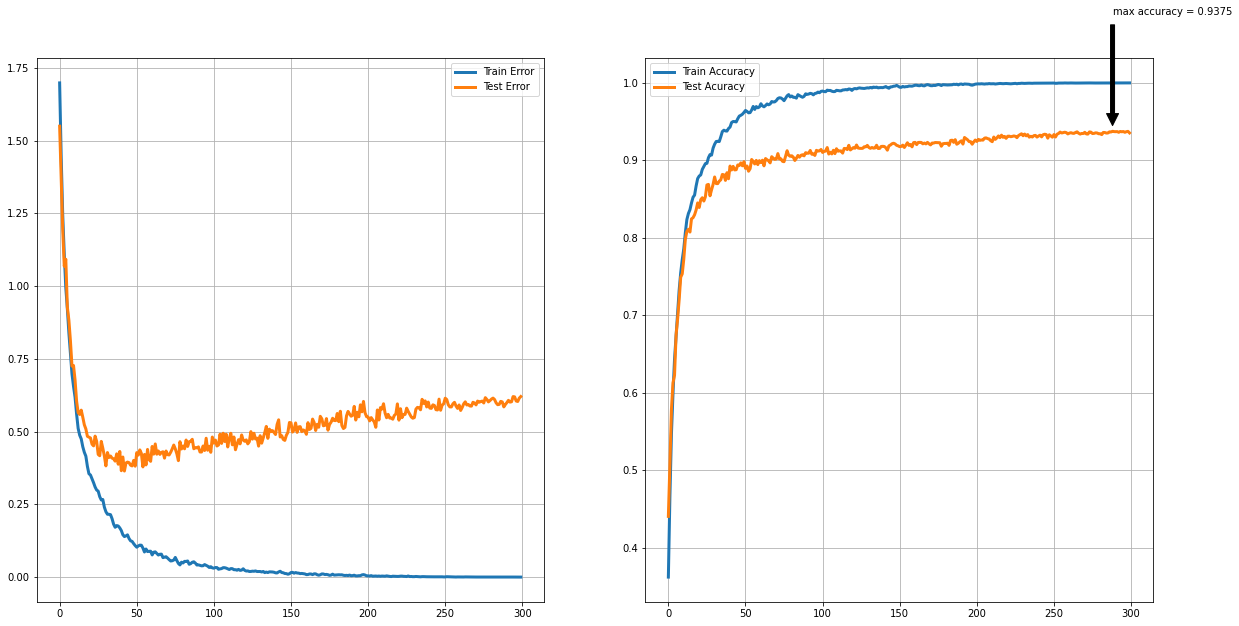

In [ ]:
f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(train_loss)
fig1.plot(range(n), train_loss, '-', linewidth='3', label='Train Error')
fig1.plot(range(n), test_loss, '-', linewidth='3', label='Test Error')
fig2.plot(range(n), train_accuracy, '-', linewidth='3', label='Train Accuracy')
fig2.plot(range(n), test_accuracy, '-', linewidth='3', label='Test Acuracy')
fig2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))
fig1.grid(True)
fig2.grid(True)
fig1.legend()
fig2.legend()
f.savefig("./trainTestCurve.png")

In [ ]:
torch.save(model.state_dict(), '/content/model1.pt')

We tried our model with 3 different optimizer, Adam, AdaGrad and AdaDelta, and below is the bar plot with their accuracy.

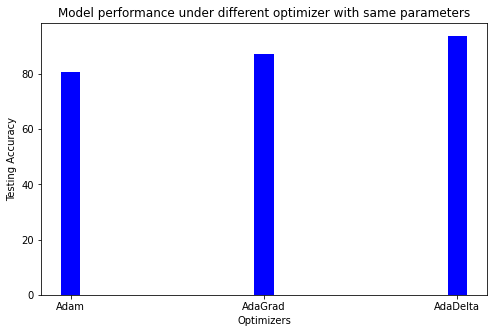

In [4]:
import matplotlib.pyplot as plt 
  
# creating the dataset
data = {'Adam':80.67, 'AdaGrad':87.23, 'AdaDelta':93.75,}
optimizer = list(data.keys())
accuracy = list(data.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(optimizer, accuracy, color ='blue',
        width = 0.1)
 
plt.xlabel("Optimizers")
plt.ylabel("Testing Accuracy")
plt.title("Model performance under different optimizer with same parameters")
plt.show()